<a href="https://www.kaggle.com/code/anastasiyamikheeva/ump-eda-dnn?scriptVersionId=96306401" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import lightgbm
from scipy.stats import probplot, pearsonr
from sklearn.model_selection import StratifiedKFold 
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Ubiquant Market Prediction

[Соревнование на Kaggle](https://www.kaggle.com/c/ubiquant-market-prediction)


1. Обзор данных
   - Описание датасета 
   - Target
   - Investment ID
   - Time Id
   
    
2. Выбор признаков
   - Корелляция
   - Lightbgm
    
   
3. Обучение модели
   - Linear Regression
   - DNN
   
   
4. Future work


<h1>
    <div style="color:black;
           border-radius:5px;
           background-color:#629b50">
1.Обзор данных
</h1>

## Описание датасета

Я использовала датасет [в формате parquet](https://www.kaggle.com/robikscube/ubiquant-parquet) для более быстрой загрузки данных.

**train.parquet**:

* `row_id` - A unique identifier for the row.

* `time_id` - The ID code for the time the data was gathered. The time IDs are in order, but the real time between the time IDs is not constant and will likely be shorter for the final private test set than in the training set.

* `investment_id`- The ID code for an investment. Not all investment have data in all time IDs.

* `target` - The target.

* `[f_0:f_299]` - Anonymized features generated from market data.


In [2]:
colors = sns.color_palette('gist_earth_r', 20)

In [3]:
colors

[(0.9395643281675277, 0.8544224428624954, 0.8424569738376937),
 (0.8869286563350552, 0.75841802832244, 0.7006139476753874),
 (0.8342929845025828, 0.6922737254901962, 0.5786758598521375),
 (0.7816573126701105, 0.6515126582278481, 0.46338602807243123),
 (0.7454803965044998, 0.6594903743315508, 0.3899072103088727),
 (0.7241726272770749, 0.7035188948306594, 0.37379467833956326),
 (0.6659315436241611, 0.7033517006802721, 0.35892157190635454),
 (0.5883318594551915, 0.6827034413765506, 0.34404846547314577),
 (0.5107321752862218, 0.6620551820728292, 0.32917535903993705),
 (0.41964151123864174, 0.6414069227691077, 0.3090692852140856),
 (0.30632035128907437, 0.6125916387959867, 0.27935239845938376),
 (0.25661406784936197, 0.5855013377926422, 0.32284437777281283),
 (0.23441852296474144, 0.5584110367892977, 0.38044866745395933),
 (0.21222297808012094, 0.5313207357859532, 0.4380529571351057),
 (0.19002743319550042, 0.5042304347826088, 0.49565724681625223),
 (0.15680719880019997, 0.4275524996057404, 0.4918608858682915),
 (0.12544575904015998, 0.34751263818752554, 0.48333030232013124),
 (0.09408431928011998, 0.25456763098682095, 0.4747997187719709),
 (0.06272287952007999, 0.1532286827246087, 0.46626913522381064),
 (0.031361439760039994, 0.04498767064541501, 0.45773855167565036)]

In [4]:
train = pd.read_parquet('../input/ubiquant-parquet/train.parquet', engine='pyarrow') 
train.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float64(301), int64(2), object(1)
memory usage: 7.1+ GB


In [6]:
print('Rows and Columns in train dataset:', train.shape)
print('Missing values in train dataset:', sum(train.isnull().sum()))

Rows and Columns in train dataset: (3141410, 304)
Missing values in train dataset: 0


### Target

In [7]:
def dist_target(target, title, label):

    fig, axes = plt.subplots(ncols=2, figsize=(24, 6), dpi=100)
    sns.distplot(x=target, bins=50, color= '#629b50', ax=axes[0])
    axes[0].axvline(x=np.mean(target), color='black')
    axes[0].set_title(title)
    axes[0].set_xlabel(label)
    axes[0].set_ylabel('Частота')
    
    probplot(target, plot=axes[1])
    axes[1].get_lines()[0].set_marker('p')
    axes[1].get_lines()[0].set_color('#629b50')
    axes[1].get_lines()[1].set_color('black')

plt.show()


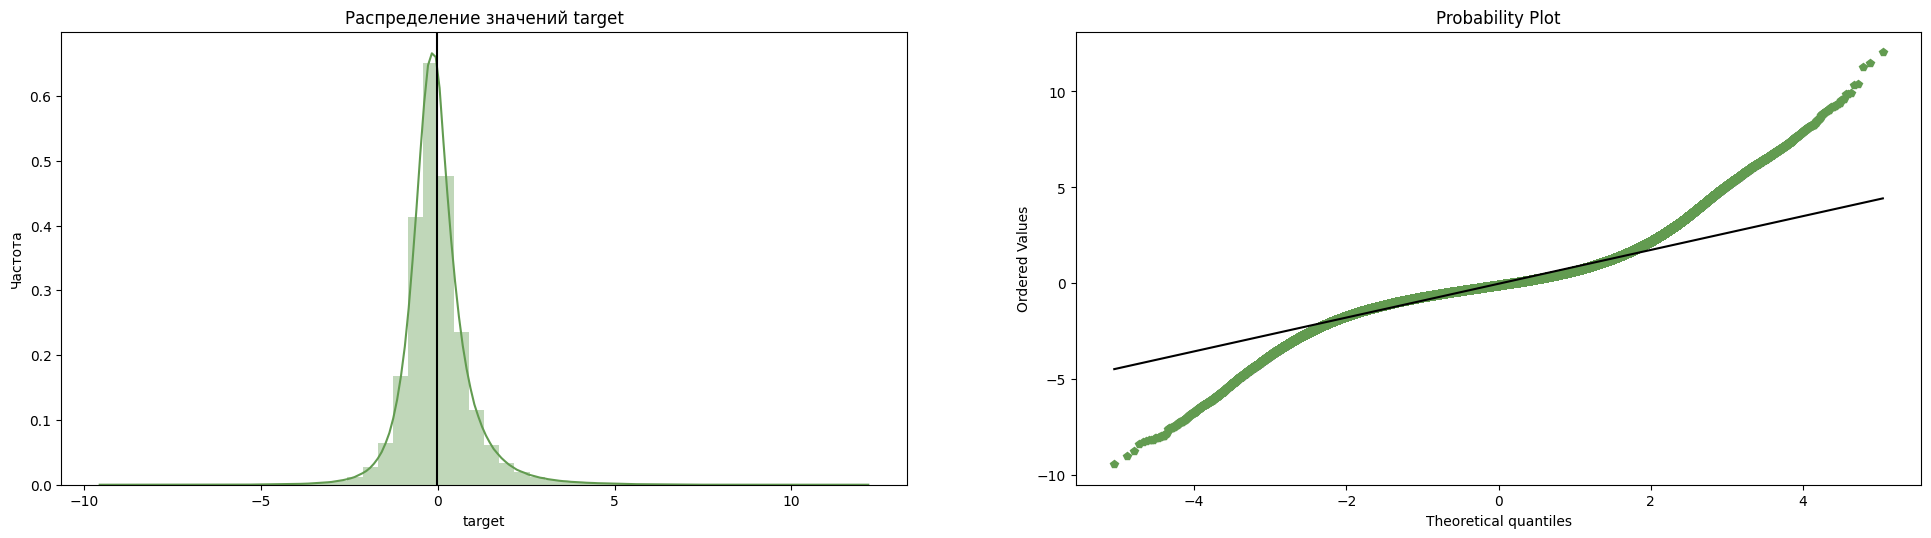

In [8]:
dist_target(train['target'], title='Распределение значений target', label='target')

In [9]:
train['target'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).to_frame().T

,count,mean,std,min,1%,25%,50%,75%,99%,max
target,3141410.0,-0.021092,0.919706,-9.419646,-2.21572,-0.500457,-0.09717,0.357291,3.024369,12.038613


Распределение имеет форму, похожую на нормальное, но с более тяжелыми хвостами.

### Investment ID

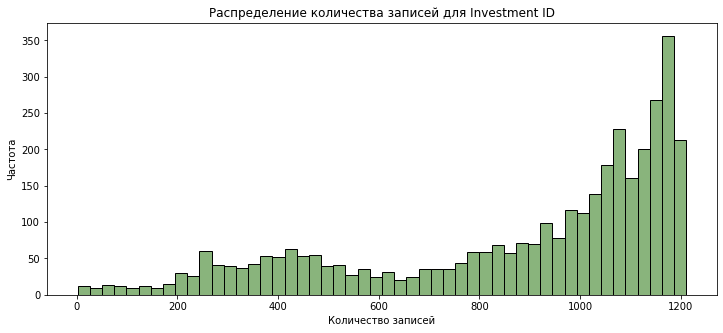

In [10]:
plt.figure(figsize = (12, 5))
sns.histplot(x=train.groupby(['investment_id'])['target'].count(), bins=50, color='#629b50')
plt.title('Распределение количества записей для Investment ID')
plt.xlabel('Количество записей')
plt.ylabel('Частота')
plt.show()

Выше я смотрела на распределение значений таргета. Посмотрим теперь, как будет выглядеть распределение значений таргета, усредненных по активам:

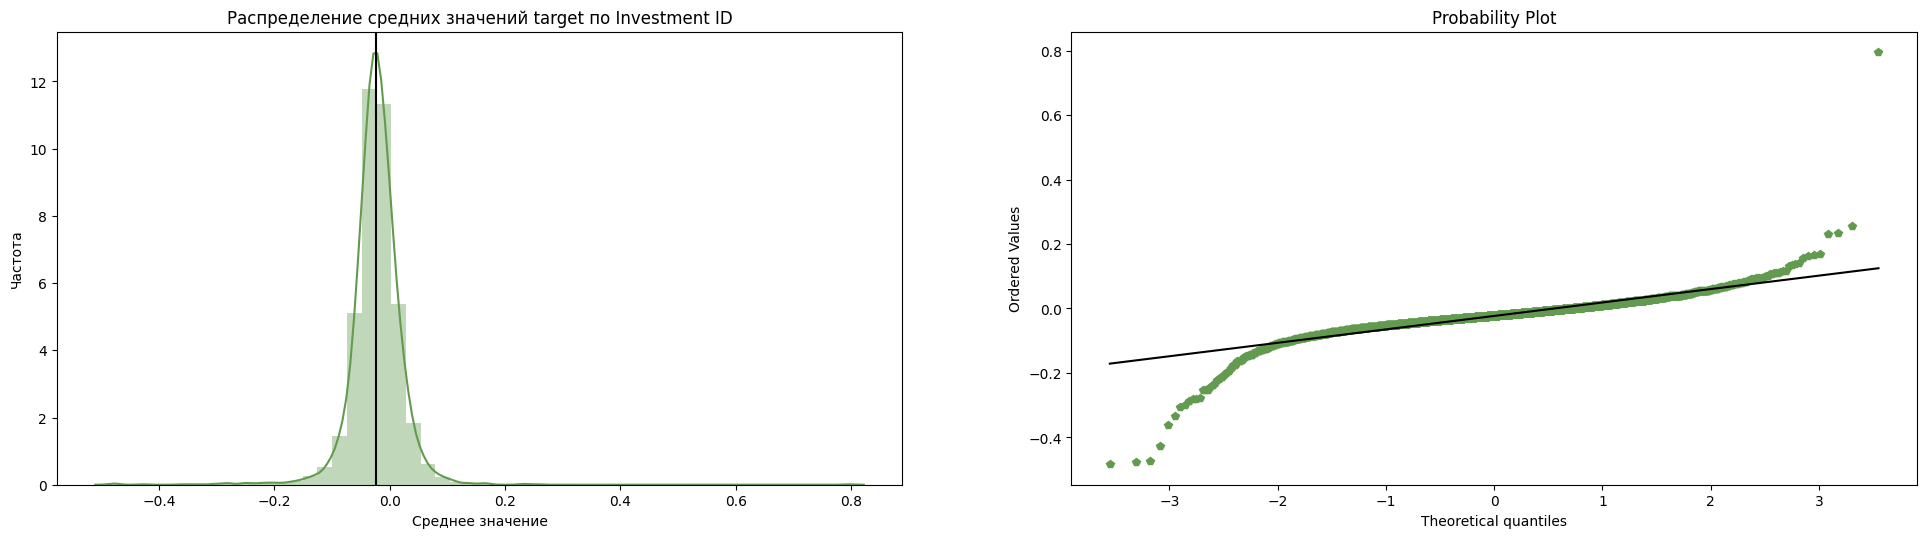

In [11]:
mean_target = train.groupby(['investment_id'])['target'].mean()
dist_target(mean_target, title='Распределение средних значений target по Investment ID', label='Среднее значение')

In [12]:
mean_target.describe([0.01, 0.25, 0.5, 0.75, 0.99]).to_frame().T

,count,mean,std,min,1%,25%,50%,75%,99%,max
target,3579.0,-0.023101,0.046359,-0.482986,-0.157878,-0.042075,-0.022694,-0.001671,0.08315,0.794976


По сравнению с распределением всех значений таргета, в этом случае уменьшается дисперсия. 

Посмотрим, как среднее значение и STD зависят от количества наблюдений:

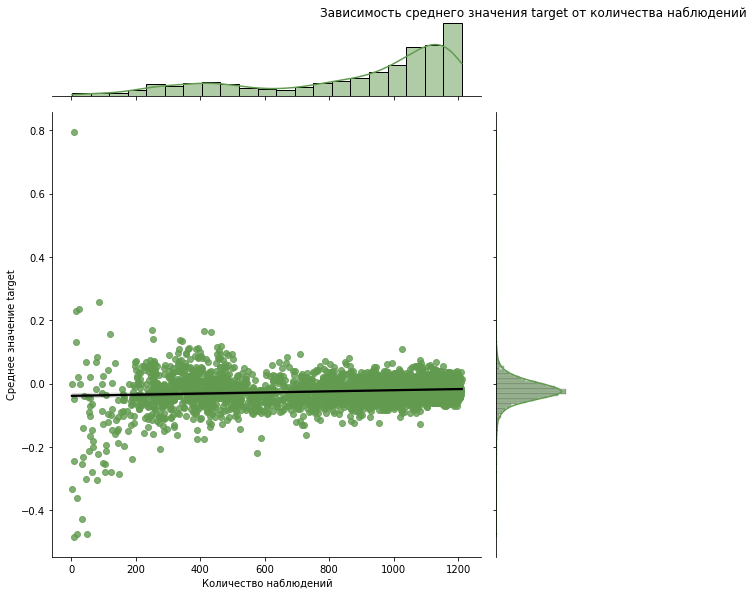

In [13]:
axes = sns.jointplot(
              x=train.groupby(['investment_id'])['target'].count().values, 
              y=train.groupby(['investment_id'])['target'].mean(), 
              kind='reg', 
              height=8, 
              joint_kws={'line_kws':{'color':'black'}},
              color='#629b50'
              )

axes.ax_joint.set_xlabel('Количество наблюдений')
axes.ax_joint.set_ylabel('Среднее значение target')

plt.title('Зависимость среднего значения target от количества наблюдений', y=1.2)
plt.show()

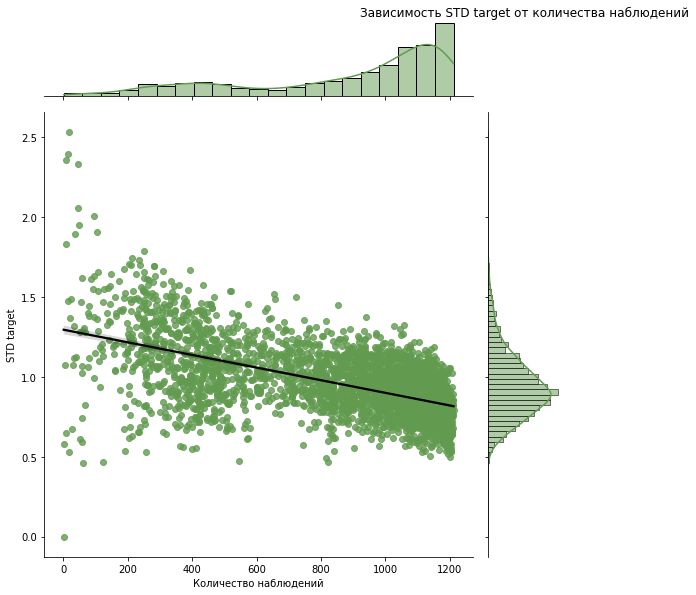

In [14]:
axes = sns.jointplot(
              x=train.groupby(['investment_id'])['target'].count().values, 
              y=train.groupby(['investment_id'])['target'].std(), 
              kind='reg', 
              height=8, 
              joint_kws={'line_kws':{'color':'black'}},
              color='#629b50'
              )

axes.ax_joint.set_xlabel('Количество наблюдений')
axes.ax_joint.set_ylabel('STD target')

plt.title('Зависимость STD target от количества наблюдений', y=1.2)
plt.show()

Чем больше наблюдений, тем меньше разброс средних значений.

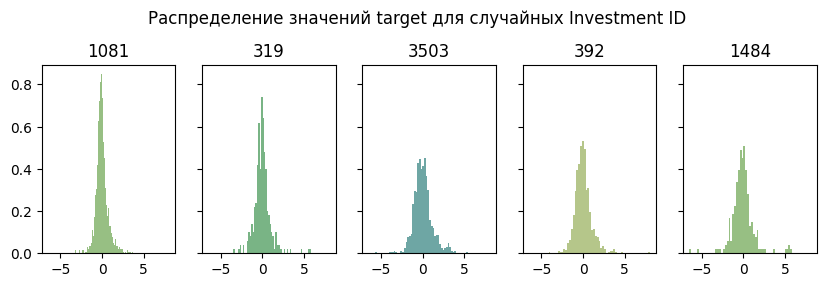

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(10, 2.5), dpi=100, sharex=True, sharey=True)

for i, (ax, investment_id) in enumerate(zip(axes.flatten(), np.random.choice(train["investment_id"].unique(),5))):
    x = train.loc[train.investment_id==investment_id, 'target']
    ax.hist(x, alpha=0.7, bins=55, density=True, stacked=True, label=str(investment_id), 
            color = random.choice(sns.color_palette('gist_earth_r', 20)))
    ax.set_title(investment_id)
    
plt.suptitle('Распределение значений target для случайных Investment ID', y=1.1)  
plt.show()

### Time ID

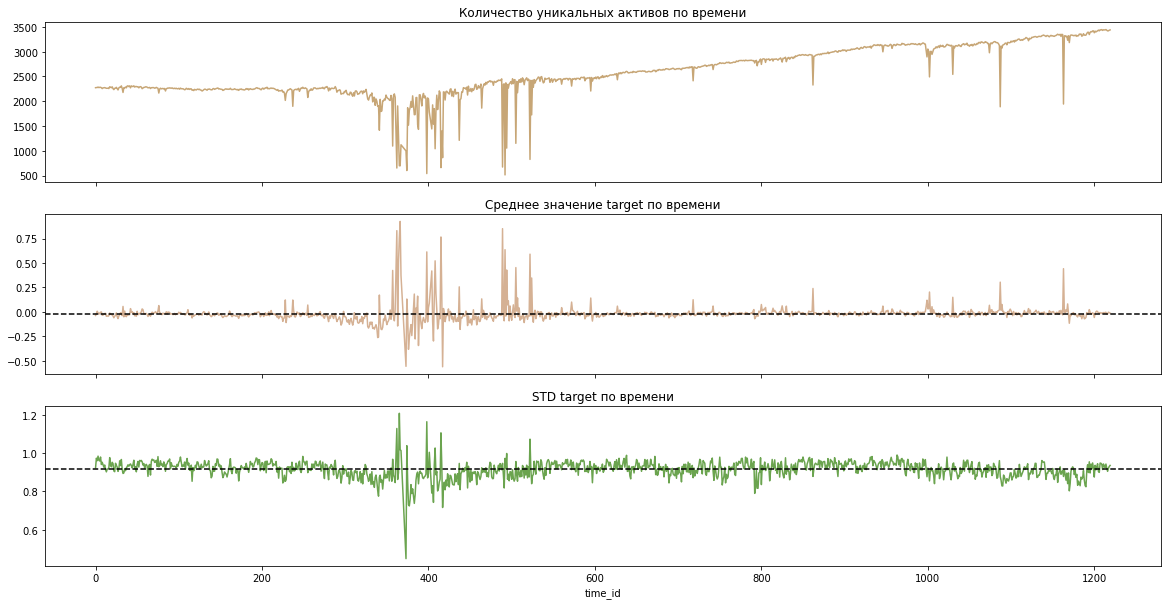

In [16]:
fig, axes = plt.subplots(3, figsize=(20, 10), sharex=True)

train.groupby('time_id')['investment_id'].nunique().plot(color=random.choice(colors), ax=axes[0])
axes[0].set_title('Количество уникальных активов по времени')

train.groupby('time_id')['target'].mean().plot(color=random.choice(colors), ax=axes[1])
axes[1].set_title("Среднее значение target по времени")
axes[1].axhline(y=np.mean(mean_target), color='black', linestyle='--', label="mean")


train.groupby('time_id')['target'].std().plot(color=random.choice(colors), ax=axes[2])
axes[2].set_title("STD target по времени")
axes[2].axhline(y=np.mean(train.groupby('time_id')['target'].std()), color='black', linestyle='--', label="mean")

plt.show()

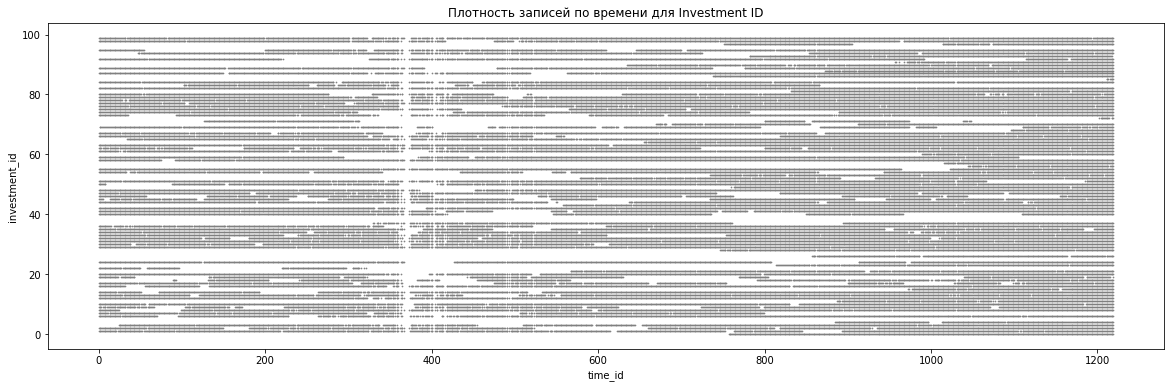

In [17]:
train[['investment_id', 'time_id']] \
    .loc[train['investment_id'] < 100] \
    .plot.scatter('time_id', 'investment_id', figsize=(20, 6), s=0.5, color='grey')

plt.title('Плотность записей по времени для Investment ID')
plt.show()

Выводы:
* В момент времени около 400 есть аномалии, для многих активов отсутствуют записи.
* По этим графикам видно, что существует некоторая обратная зависимость между средним значением таргета и количеством уникальных записей активов в этот день. Возможно, имеет смысл добавить к каждому time_id количество уникальных активов в этот момент. 
* Временной ряд средних значений таргета не имеет тренда
* Сезонности на первый взгляд нет, однако промежутки между time_id не постоянны и нельзя сказать точно.

<h1>
    <div style="color:black;
           border-radius:5px;
           background-color:#629b50">
2. Выбор признаков
</h1>

Я использовала 1% рандомно выбранных данных, чтобы ускорить процесс.  
Выбор признаков осложняется тем, что они анонимны.

In [18]:
features = train.columns[4:]

In [19]:
features_t = train.columns[3:]

### Корелляция признаков между собой

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


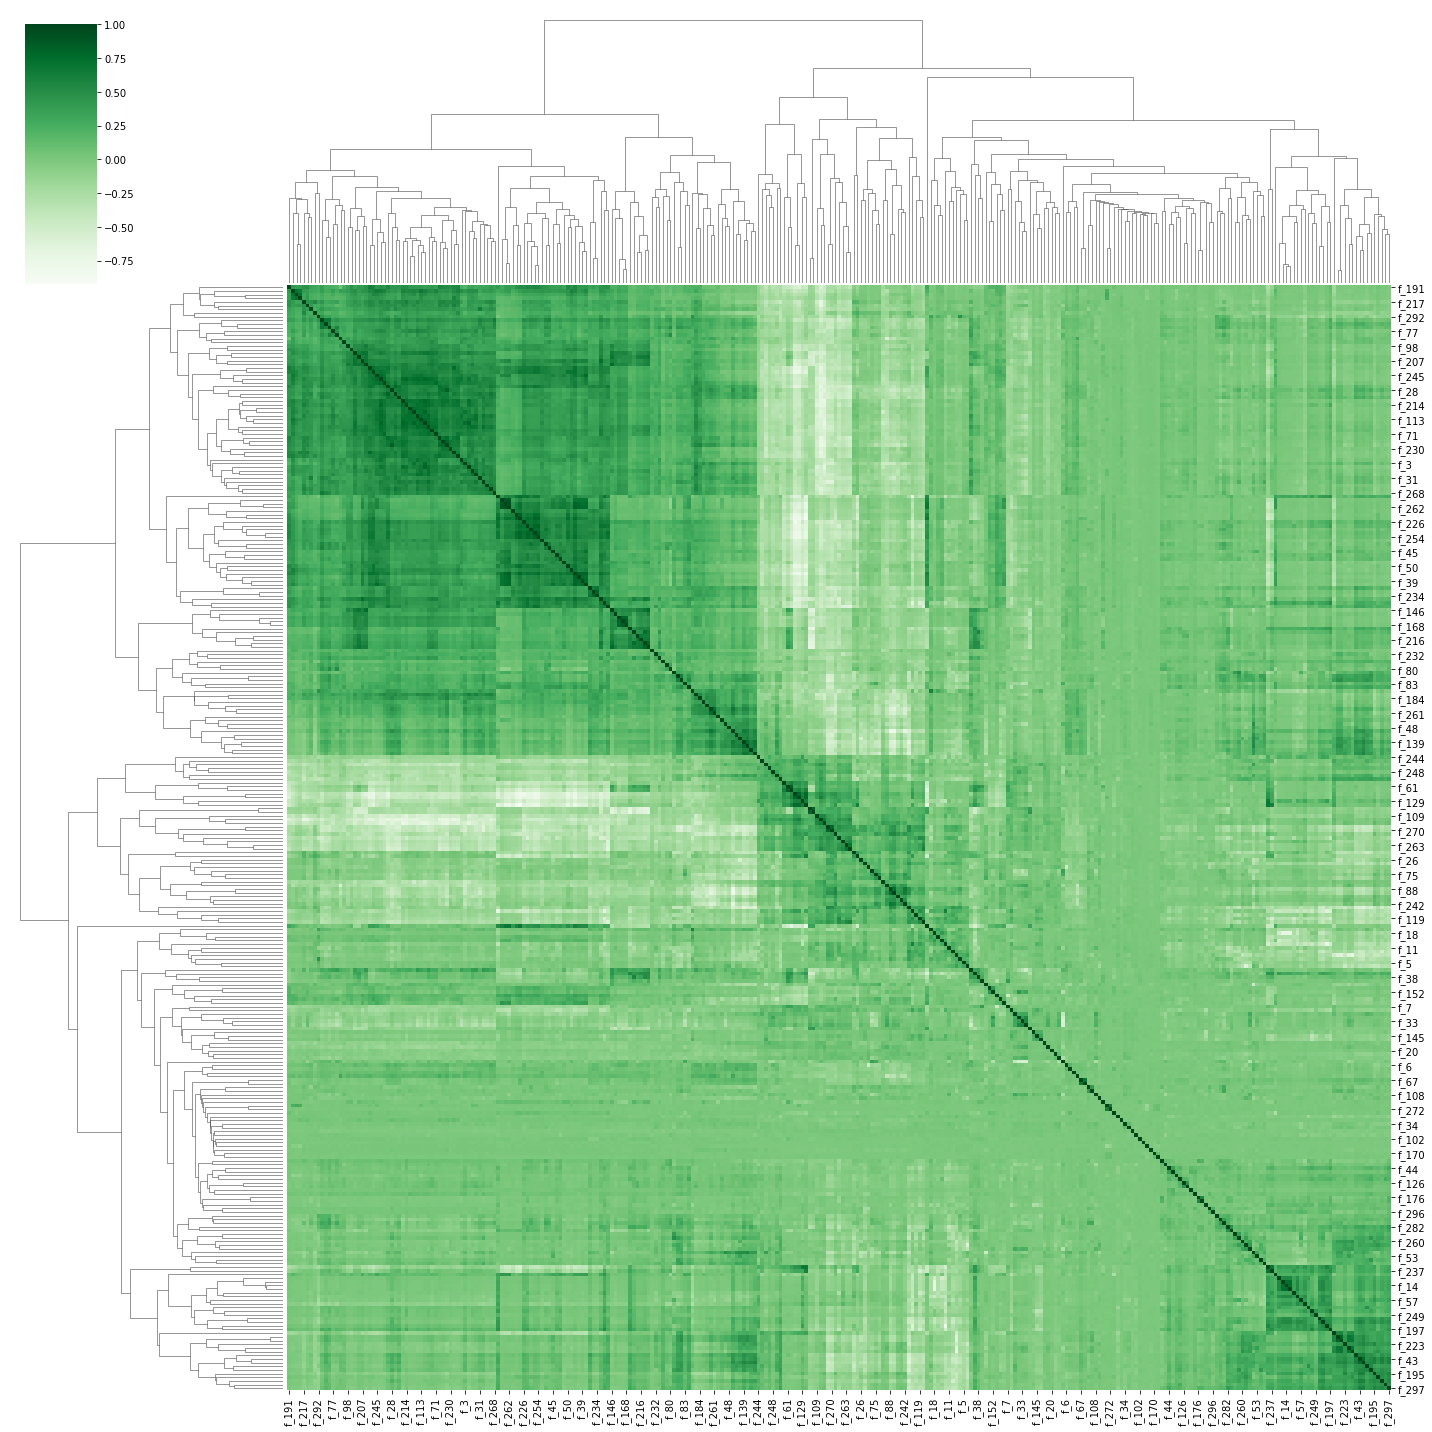

In [20]:
sample_corr = train.sample(frac=0.01, random_state=42)
correlation = sample_corr[features_t].corr()

sns.clustermap(correlation, figsize=(20, 20), cmap='Greens')

Видно, что есть сильно скореллированные между собой признаки, как отрицательно, так и положительно. Возможно, от таких пар стоит избавиться - они передают одинаковую информацию.

### Корелляция признаков и таргета

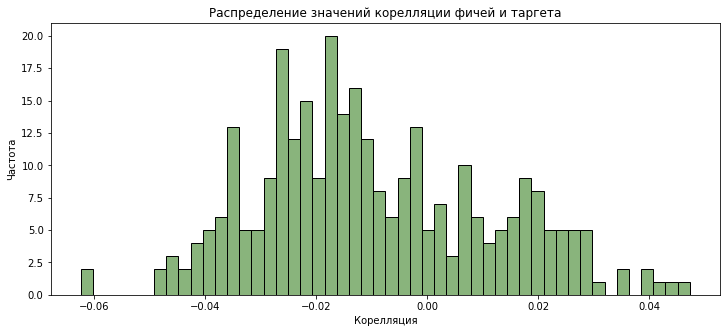

In [21]:
plt.figure(figsize=(12, 5))
sns.histplot(x=correlation['target'].iloc[1:], bins=50, color='#629b50')
plt.title('Распределение значений корелляции фичей и таргета')
plt.xlabel('Корелляция')
plt.ylabel('Частота')
plt.show()

In [22]:
correlation['target'].iloc[1:].describe([0.01, 0.25, 0.5, 0.75, 0.99]).to_frame().T

,count,mean,std,min,1%,25%,50%,75%,99%,max
target,300.0,-0.00973,0.020877,-0.062399,-0.047108,-0.024727,-0.013654,0.005743,0.039746,0.047355


Большой корелляции между фичами и таргетом не наблюдается. Посмотрим на топ 20 фичей по корелляции, но выбрать лучшие признаки это не поможет.

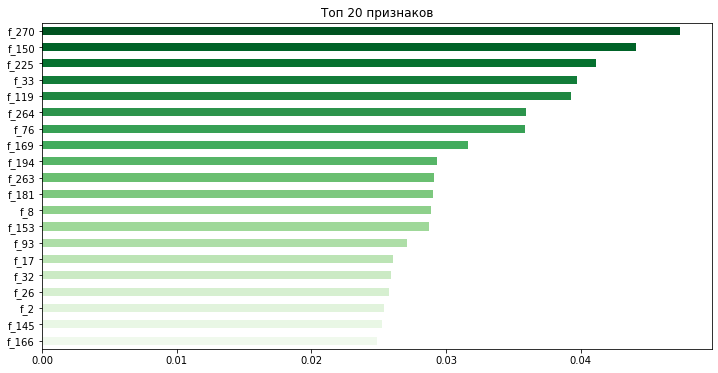

In [23]:
feat_importances_t = correlation['target'].iloc[1:]
feat_importances_t.nlargest(20).plot(kind='barh', figsize=(12, 6),
                                   color=sns.color_palette('Greens_r', 20)).invert_yaxis()
plt.title('Топ 20 признаков')
plt.show()

Уже выяснили, что есть связь между количеством активов в time_id и средним значением таргета.  
Возможно есть зависимость количества наблюдений для актива и фичами. Заменим investment ID на количество наблюдений

In [24]:
s_train=train.sample(frac=0.01, random_state = 42)

In [25]:
obs_by_asset = s_train.groupby(['investment_id'])['target'].count().to_dict()
target = s_train.investment_id.copy().replace(obs_by_asset).astype(np.int16)
features = s_train.columns[4:]

del(obs_by_asset)

In [26]:
corrs = []
for col in features:
    corr = np.corrcoef(target, s_train[col])[0][1]
    corrs.append(corr)
    
del(target)

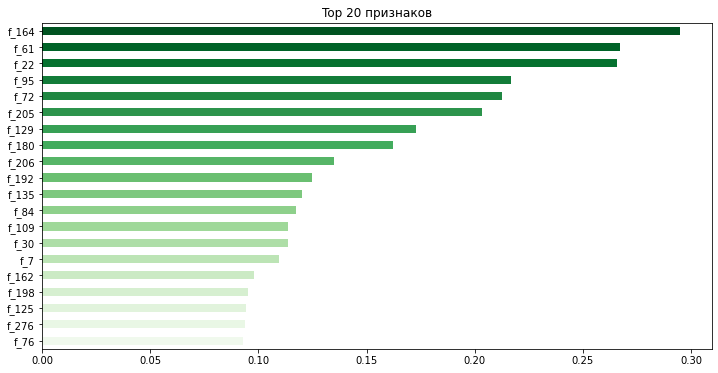

In [27]:
feat_importances = pd.Series(corrs, index=features)
feat_importances.nlargest(20).plot(kind='barh', figsize=(12, 6),
                                   color=sns.color_palette('Greens_r', 20)).invert_yaxis()
plt.title('Top 20 признаков')
plt.show()

Действительно есть корелляция для нескольких признаков.  
Можно попробовать добавить еще признаки - количество наблюдений актива за все время.

## Lgbm Feature Importance 


Еще один способ найти наиболее значимые признаки - обучить модель и взять признаки с наибольшим весом.

In [28]:

features = [f'f_{i}' for i in range(300)]
    
target = 'target'

In [29]:
seed = 8
folds = 5

skf = StratifiedKFold(folds, shuffle = True, random_state = seed)

for train_index, test_index in skf.split(s_train, s_train['investment_id']):
    train1 = s_train.iloc[train_index]
    valid1 = s_train.iloc[test_index]
    
    lgbm = LGBMRegressor(
        num_leaves=2 ** np.random.randint(3, 8),
        learning_rate = 10 ** (-np.random.uniform(0.1, 2)),
        n_estimators = 1000,
        min_child_samples = 1000, 
        subsample=np.random.uniform(0.5, 1.0), 
        subsample_freq=1,
        n_jobs= -1
    )

    lgbm.fit(train1[features], train1[target], eval_set = (valid1[features], valid1[target]), early_stopping_rounds = 10)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 0.866616
[2]	valid_0's l2: 0.866395
[3]	valid_0's l2: 0.866263
[4]	valid_0's l2: 0.86604
[5]	valid_0's l2: 0.865923
[6]	valid_0's l2: 0.865811
[7]	valid_0's l2: 0.865623
[8]	valid_0's l2: 0.865428
[9]	valid_0's l2: 0.865278
[10]	valid_0's l2: 0.865142
[11]	valid_0's l2: 0.864983
[12]	valid_0's l2: 0.864792
[13]	valid_0's l2: 0.864662
[14]	valid_0's l2: 0.864473
[15]	valid_0's l2: 0.864355
[16]	valid_0's l2: 0.86422
[17]	valid_0's l2: 0.864122
[18]	valid_0's l2: 0.864022
[19]	valid_0's l2: 0.863865
[20]	valid_0's l2: 0.863832
[21]	valid_0's l2: 0.863721
[22]	valid_0's l2: 0.863599
[23]	valid_0's l2: 0.863484
[24]	valid_0's l2: 0.86344
[25]	valid_0's l2: 0.863323
[26]	valid_0's l2: 0.863253
[27]	valid_0's l2: 0.863149
[28]	valid_0's l2: 0.862962
[29]	valid_0's l2: 0.86286
[30]	valid_0's l2: 0.862758
[31]	valid_0's l2: 0.862646
[32]	valid_0's l2: 0.862578
[33]	valid_0's l2: 0.862487
[34]	valid_0's l2: 0.862528
[35]	valid_0's l2: 0.86248
[36]	valid_0's l2: 0.862433
[37]	v

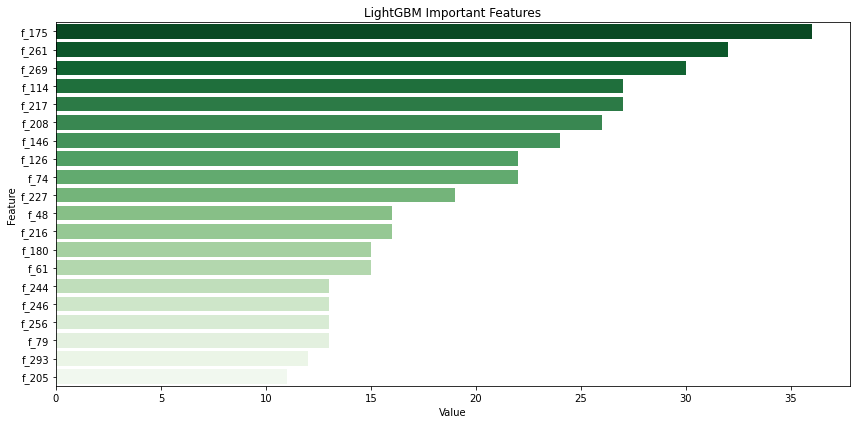

In [30]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_, s_train.columns)), columns=['Value', 'Feature']).nlargest(20, 'Value')

plt.figure(figsize=(12, 6))
sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False),  palette='Greens_r')
plt.title('LightGBM Important Features')
plt.tight_layout()
plt.show()

Посмотрим на распределение топ-9 фичей

In [31]:
top_f = feature_imp.iloc[:9].Feature.to_list()

In [32]:
cols = ["row_id","time_id","investment_id","target"].append(top_f)

In [33]:
df = pd.DataFrame(s_train, columns= cols)
df.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
3045449,1191_3457,1191,3457,-0.179413,0.439238,-1.072283,0.291426,-0.148154,-0.212617,-0.663309,...,1.703883,-1.433295,-0.223799,0.165447,-1.149793,-0.528342,-0.805426,-0.878537,1.077329,-0.445870
120305,52_3303,52,3303,0.421349,-1.034843,0.765246,0.475484,-0.619716,-0.255421,-0.409988,...,0.297707,1.128039,-0.698337,0.834049,2.768384,-0.633694,-1.559373,1.987836,-0.674413,-0.560534
1976592,850_2176,850,2176,-0.631677,-0.583853,-0.355985,-0.140862,-0.308016,0.102722,2.207325,...,0.572746,-0.542923,1.680173,-0.027177,0.910336,0.118505,-0.720434,-0.281432,0.483735,0.660234
940575,446_1718,446,1718,-0.142380,1.277806,0.633990,0.413741,-0.744958,-0.485497,0.935166,...,0.229207,-0.668771,-0.356738,0.301932,0.630244,-0.767518,0.959880,-0.848486,0.000000,-0.951001
2730285,1095_2809,1095,2809,-1.171863,1.112329,1.939695,-4.328801,0.960344,-0.154264,1.674004,...,-2.231416,-1.041659,-0.453389,1.602777,-0.201256,-0.338737,3.206989,-0.803102,0.415129,-0.299429


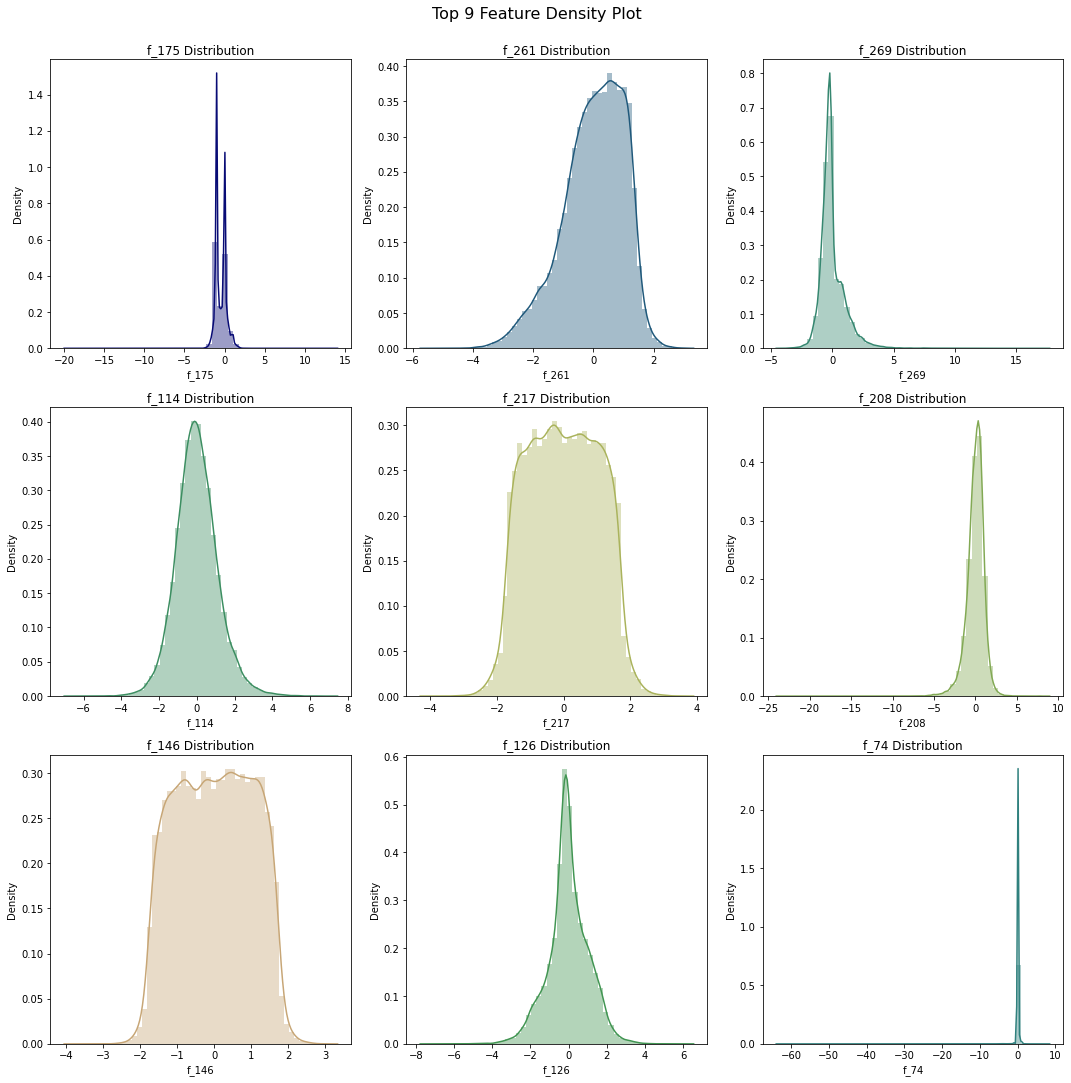

In [34]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))
for i, sample in enumerate(top_f):
    sns.distplot(df[sample], ax=ax[math.floor(i/3),i%3], color=random.choice(sns.color_palette('gist_earth_r', 20))).set_title(f'{sample} Distribution')
fig.suptitle('Top 9 Feature Density Plot', y=1, size=16) 
fig.tight_layout()
fig.show()

Фичи имеют разное распределение.

<h1>
    <div style="color:black;
           border-radius:5px;
           background-color:#629b50">
3. Обучение модели
</h1>

### Линейная регрессия

Работает очень плохо(

In [35]:
Y= s_train['target']
X = s_train[s_train.columns[4:]]

In [36]:
model = LinearRegression().fit(X, Y)
model.score(X,Y)

0.030452589978038347

In [37]:
Y_pred = model.predict(X)
lin = pd.DataFrame({'Actual': Y, 'Predicted': Y_pred.flatten()})
display(lin)

,Actual,Predicted
3045449,-0.179413,-0.104797
120305,0.421349,-0.087570
1976592,-0.631677,0.123534
940575,-0.142380,-0.074805
2730285,-1.171863,0.025439
...,...,...
2667087,0.143069,0.177917
238798,0.144855,0.029628
2786982,0.582750,0.257970
571666,-0.035158,-0.038622


### DNN

На основе этой модели были созданы почти все модели с хорошим скором на этом соревновании, поэтому я взяла ее. Архитектура не моя, но она показалась мне логичной. 

In [38]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

Создадим IntegerLookup layer для investment_id (количество уникальных значений < максимальный индекс). В файле investment_ids.csv содержатся уникальные значения investment_id. 

In [39]:
investment_ids = pd.read_csv('../input/ump-combinatorialpurgedgroupkfold-tf-record/investment_ids.csv')
investment_id_size = len(investment_ids) + 1

with tf.device('cpu'):
    investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
    investment_id_lookup_layer.adapt(investment_ids)

2022-05-22 21:23:01.253453: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-05-22 21:23:01.625213: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### Tensorflow dataset

In [40]:
def decode_function(record_bytes):
    return tf.io.parse_single_example(
      record_bytes,
      {
          'features': tf.io.FixedLenFeature([300], dtype=tf.float32),
          'time_id': tf.io.FixedLenFeature([], dtype=tf.int64),
          'investment_id': tf.io.FixedLenFeature([], dtype=tf.int64),
          'target': tf.io.FixedLenFeature([], dtype=tf.float32)
      }
  )

def preprocess(item):
    return (item['investment_id'], item['features']), item['target']

def make_dataset(file_paths, batch_size=4096, mode='train'):
    ds = tf.data.TFRecordDataset(file_paths)
    ds = ds.map(decode_function)
    ds = ds.map(preprocess)
    if mode == 'train':
        ds = ds.shuffle(batch_size * 4)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

### Модель

Категориальные (investment_id) и численные (f_i) признаки подаются на вход отдельно. 

Категориальный признак довольно разреженный (есть много investment_id), в этом случае будет хорошо применить эмбеддинг. В остальном сеть состоит из слоев с активацией 'swish' (есть мнение, что она лучше чем ReLu) и дропаута (чтобы избежать переобучения).

In [41]:
def correlation(x, y, axis=-2):
    """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
    x = tf.convert_to_tensor(x)
    y = math_ops.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    xvar = tf.reduce_sum(tf.math.squared_difference(x, xmean), axis=axis)
    yvar = tf.reduce_sum(tf.math.squared_difference(y, ymean), axis=axis)
    cov = tf.reduce_sum((x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xvar * yvar)
    
    return tf.constant(1.0, dtype=x.dtype) - corr


def get_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.1)(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.1)(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dropout(0.1)(investment_id_x)
    
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dropout(0.1)(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dropout(0.1)(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dropout(0.1)(feature_x)
    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    
    output = layers.Dense(1)(x)
    
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss='mse', metrics=['mse', "mae", "mape", rmse, correlation])
    
    return model

Архитектура 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        114560      integer_lookup[0][0]             
__________________________________________________________________________________________________
reshape (Reshape)               (None, 32)           0           embedding[0][0]                  
______________________________________________________________________________________________

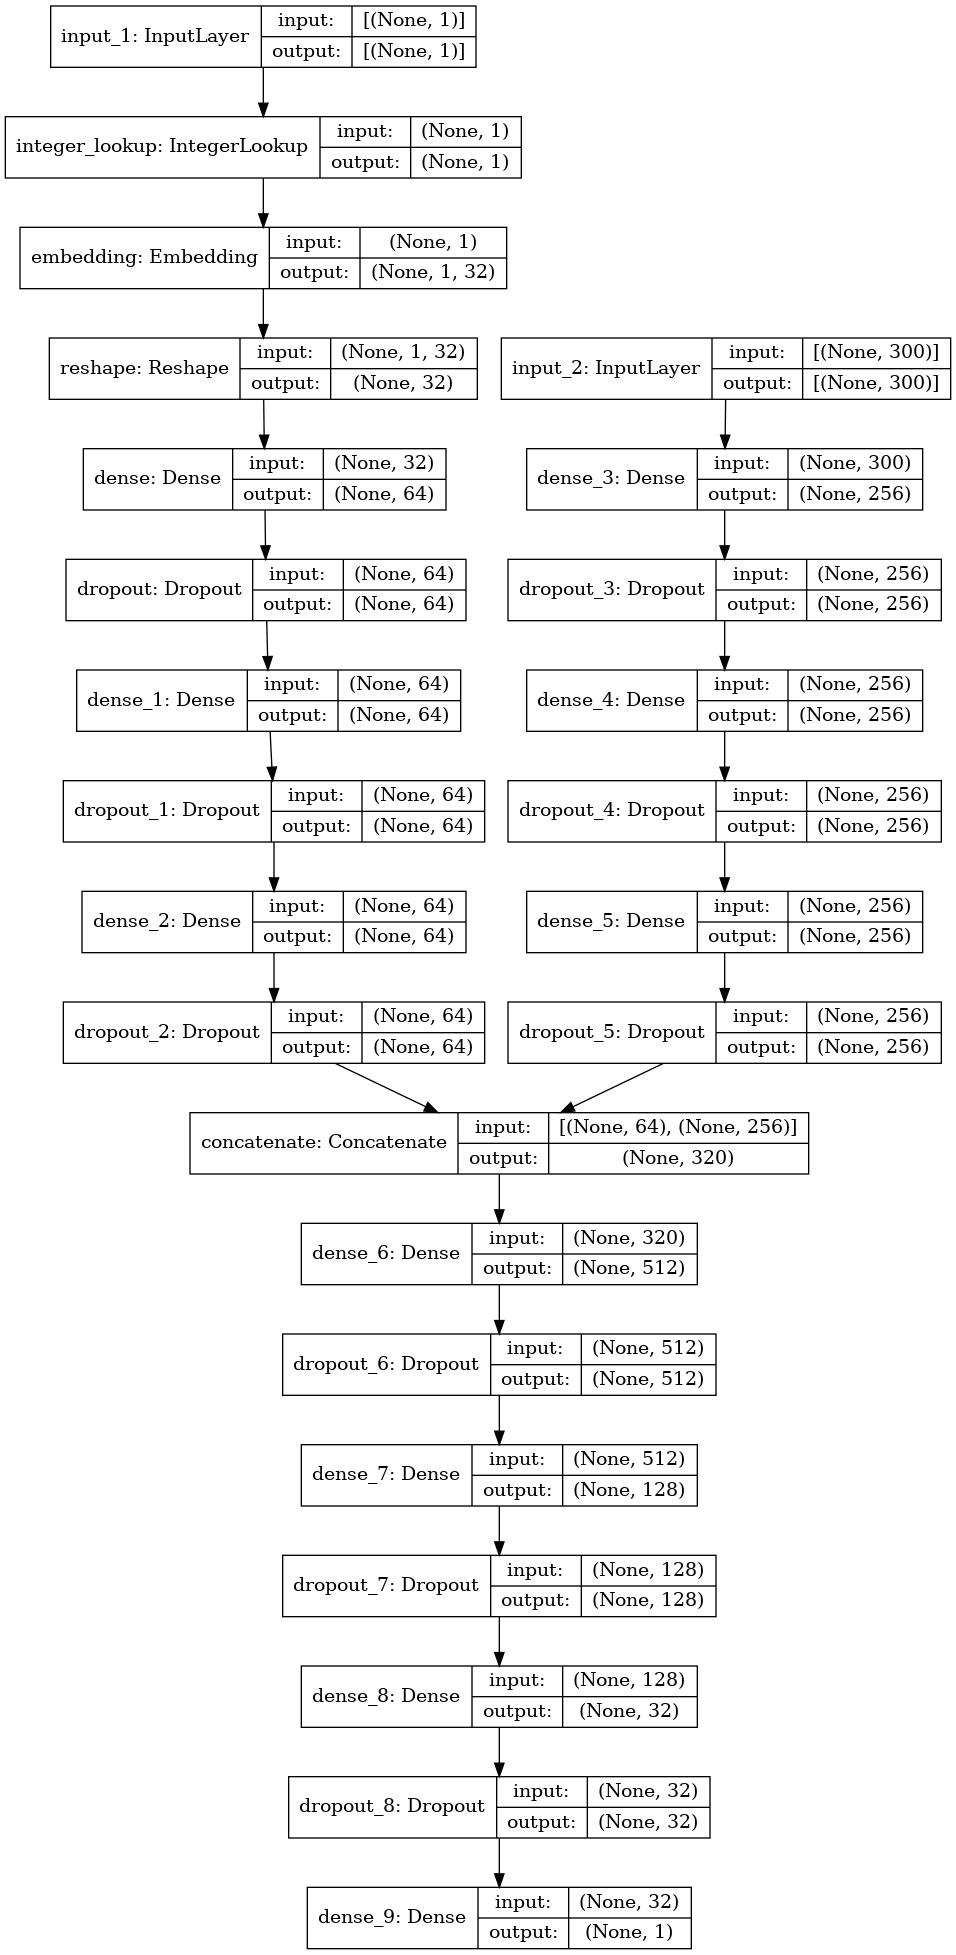

In [42]:
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

Чтобы ускорить процесс, я взяла заранее разделенные на фолды данные, которые [любезно предоставил](https://www.kaggle.com/lonnieqin/ump-combinatorialpurgedgroupkfold-tf-record) автор данного решения. Они разделены по принципу CombinatorialPurgedGroupKFold.

In [43]:
 tf_record_dataset_path = '../input/ump-combinatorialpurgedgroupkfold-tf-record/'

In [ ]:
%%time
models = []
for i in range(5):
    train_path = f'{tf_record_dataset_path}fold_{i}_train.tfrecords'
    valid_path = f'{tf_record_dataset_path}fold_{i}_test.tfrecords'
    valid_ds = make_dataset([valid_path], mode='valid')
    train_ds = make_dataset([train_path])
    model = get_model()

    checkpoint = keras.callbacks.ModelCheckpoint(f'model_{i}.tf', monitor='val_correlation', mode='min', 
                                                 save_best_only=True, save_weights_only=True)
    early_stop = keras.callbacks.EarlyStopping(patience=10)
    history = model.fit(train_ds, epochs=30, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
    model.load_weights(f"model_{i}.tf")
    
    for metric in ['loss', 'mae', 'mape', 'rmse', 'correlation']:
        pd.DataFrame(history.history, columns=[metric, f'val_{metric}']).plot()
        plt.title(metric.upper())
        plt.show()

    y_vals = []
    for _, y in valid_ds:
        y_vals += list(y.numpy().reshape(-1))
        
    y_val = np.array(y_vals)
    pearson_score = stats.pearsonr(model.predict(valid_ds).reshape(-1), y_val)[0]
    models.append(model)
    print(f'Pearson Score: {pearson_score}')

Модель показывает не самый лучший, но и не самый плохой результат. Архитектура в целом работает и ее можно улучшить:

<h1>
    <div style="color:black;
           border-radius:5px;
           background-color:#629b50">
4. Future work
</h1>

Эту модель можно улучшить:

1. Увеличить количество слоев
2. Чтобы избежать переобучения увеличить вероятность пропуска нейронов в Dropout
3. Использовать топ-100 признаков из LGBM (обучив на полном датасете)
4. Добавить новые фичи:
* Количество наблюдений в каждый time_id
* Количество наблюдений для каждого актива
* Признаки для временных рядов: несколько предыдущих наблюдений по активу, среднее значение таргета по активу


К сожалению это сделать я не успела, но обязательно попробую. 


<h1>
    <div style="color:black;
           border-radius:5px;
           background-color:#629b50">
Референсы
</h1>


    
[1] https://www.kaggle.com/robikscube/fast-data-loading-and-low-mem-with-parquet-files

[2] https://www.kaggle.com/fangya/ubiquant-investment-mini-eda-lgbm-linreg

[3] https://www.kaggle.com/kartushovdanil/the-most-advanced-analytics

[4] https://www.kaggle.com/lucamassaron/eda-target-analysis

[5] https://www.kaggle.com/lonnieqin/ubiquant-market-prediction-with-dnn

